# Lab Solution: Early Stopping and Training Monitoring

## Introduction

You've recently joined HealthTech Analytics, a healthcare AI startup that's developing systems to predict patient readmission risk based on electronic health records. As a junior data scientist, you've been tasked with implementing a neural network model, which has been showing promising results but has inconsistent performance.

Your manager explains that the model sometimes performs well, but other times it overfits to training data or fails to converge properly. She suspects that proper training monitoring and early stopping strategies might solve these issues, making the model more reliable for clinical applications.

The Chief Data Officer has emphasized that the company can't afford to waste computational resources on models that aren't learning effectively, and clinical staff need stable, reliable predictions. You'll need to implement proper training monitoring and callbacks to ensure the model trains efficiently and generalizes well to new patient data.

## Part 0: Import Libraries and Set Up Environment

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set random seeds for reproducibility
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Part 1: Load and Explore Dataset

The dataset contains information from diabetic patients with various features such as age, gender, lab results, medical history, and a target variable indicating whether the patient was readmitted within 30 days, after 30 days, or not at all.

In [2]:
# Load in Data
patient_data = pd.read_csv("readmission_data.csv")
patient_data.info()
patient_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Dataset shape: (101766, 50)
Readmission rate: readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Readmissions')

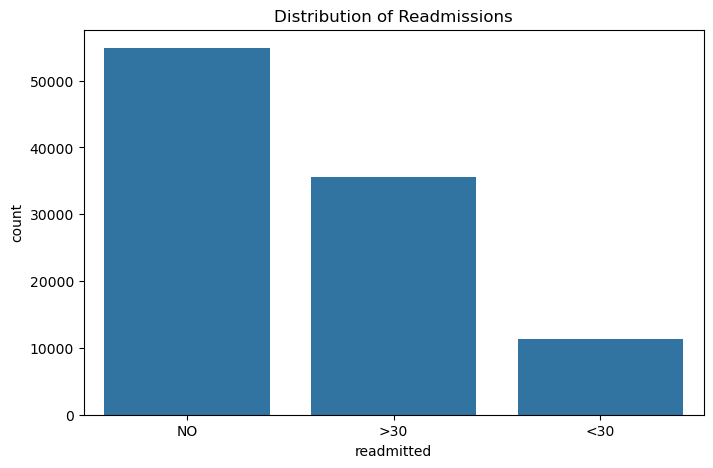

In [3]:
# Let's explore the dataset
print(f"Dataset shape: {patient_data.shape}")
print(f"Readmission rate: {patient_data['readmitted'].value_counts(normalize=True)}")

# Check class balance
plt.figure(figsize=(8, 5))
sns.countplot(x='readmitted', data=patient_data)
plt.title('Distribution of Readmissions')

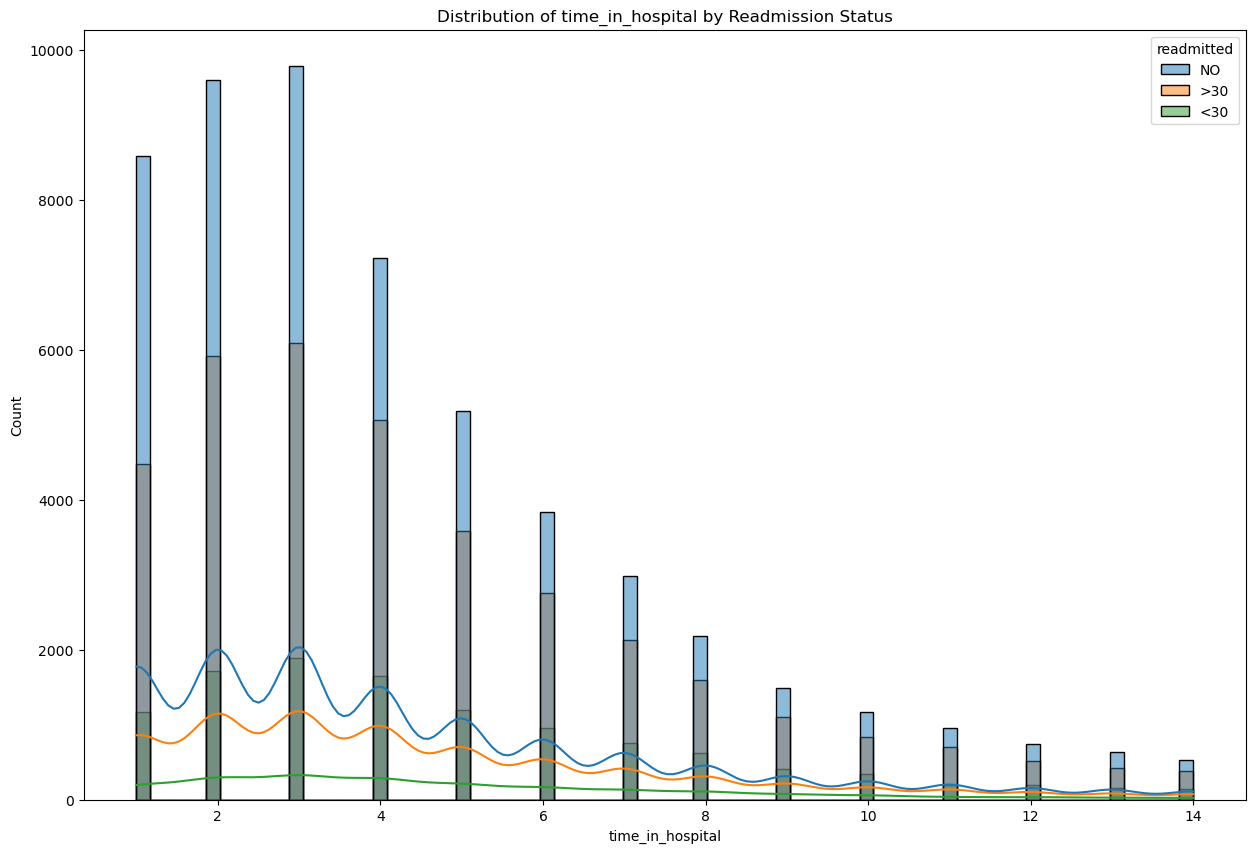

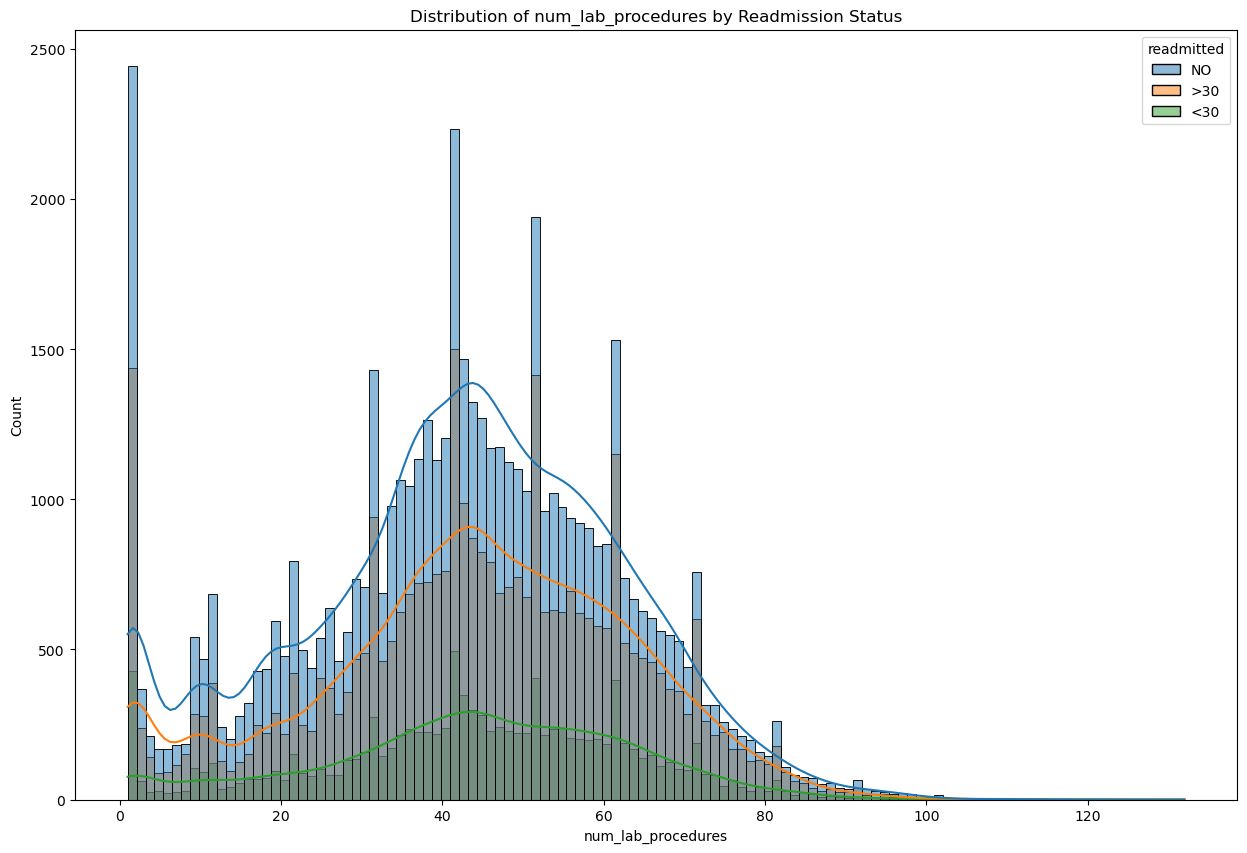

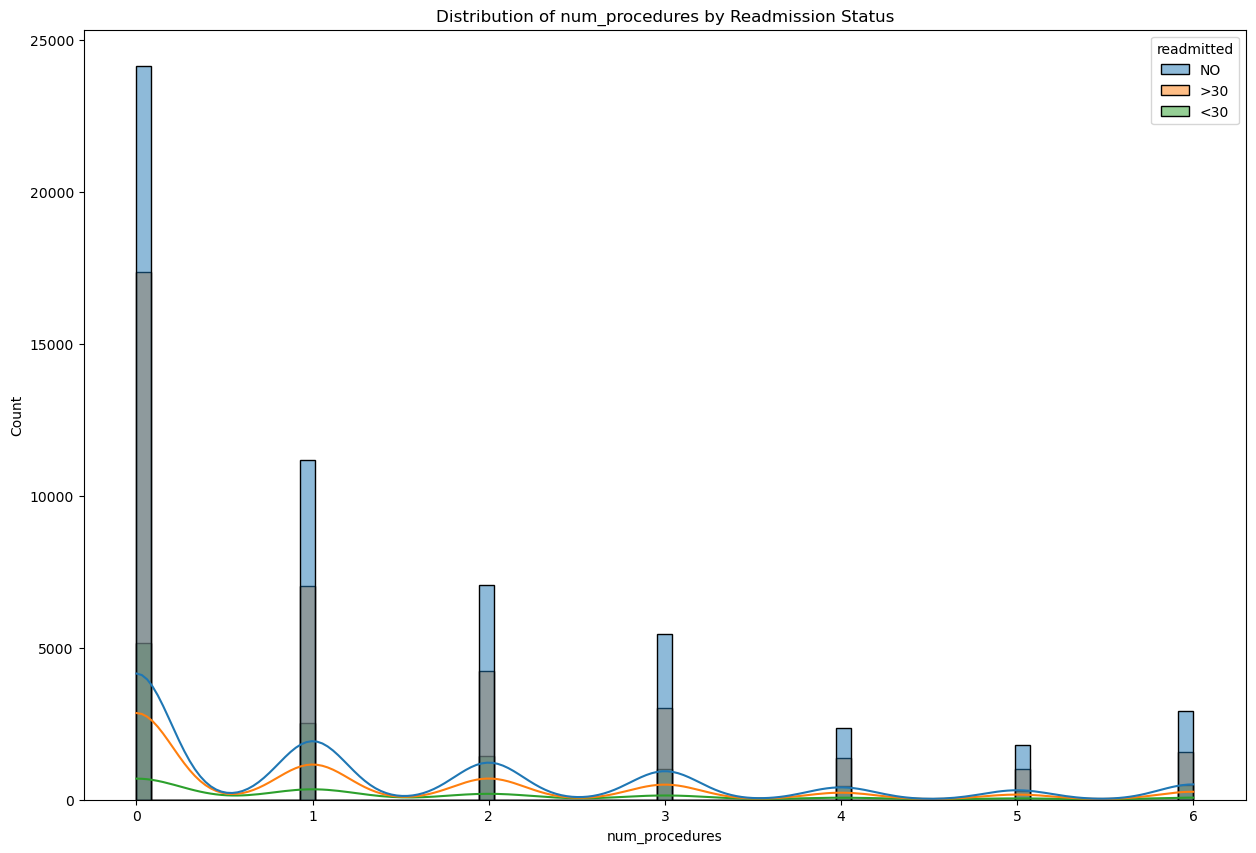

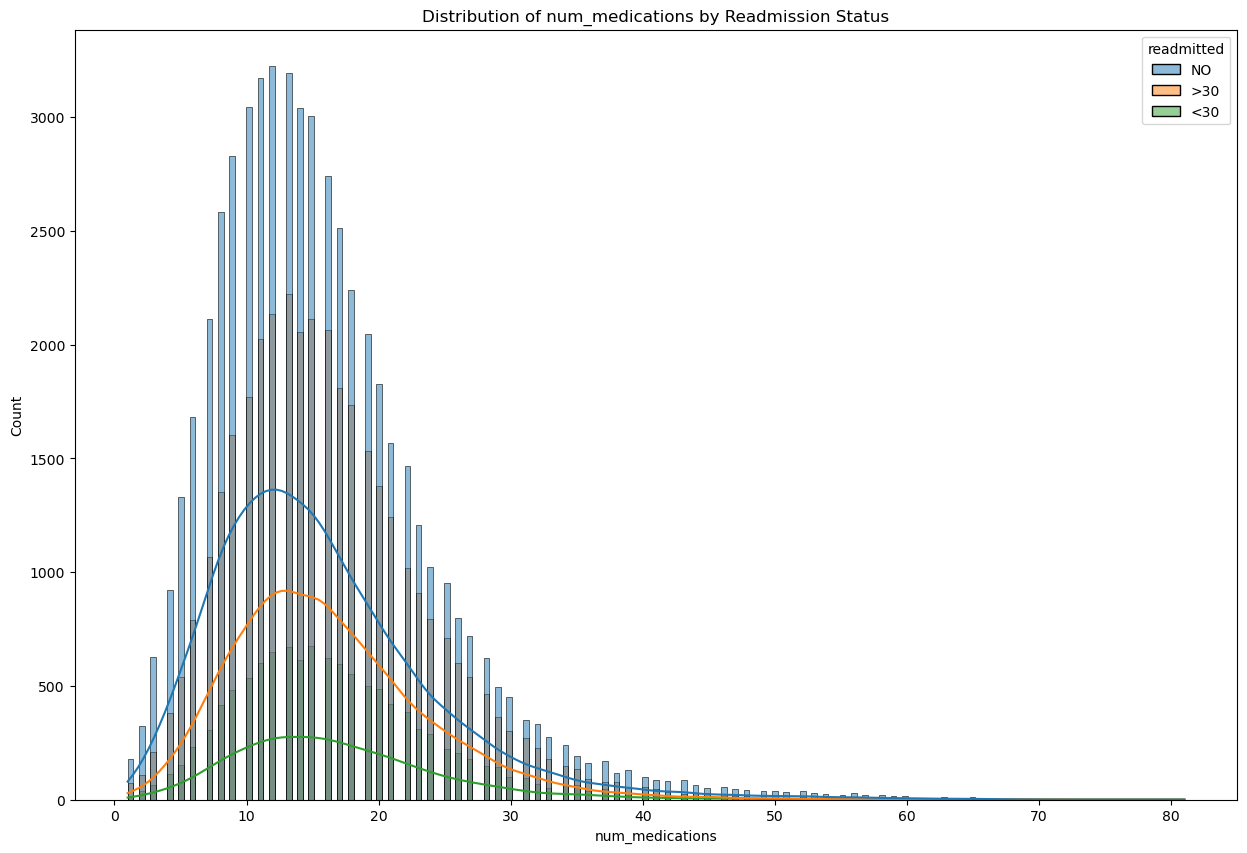

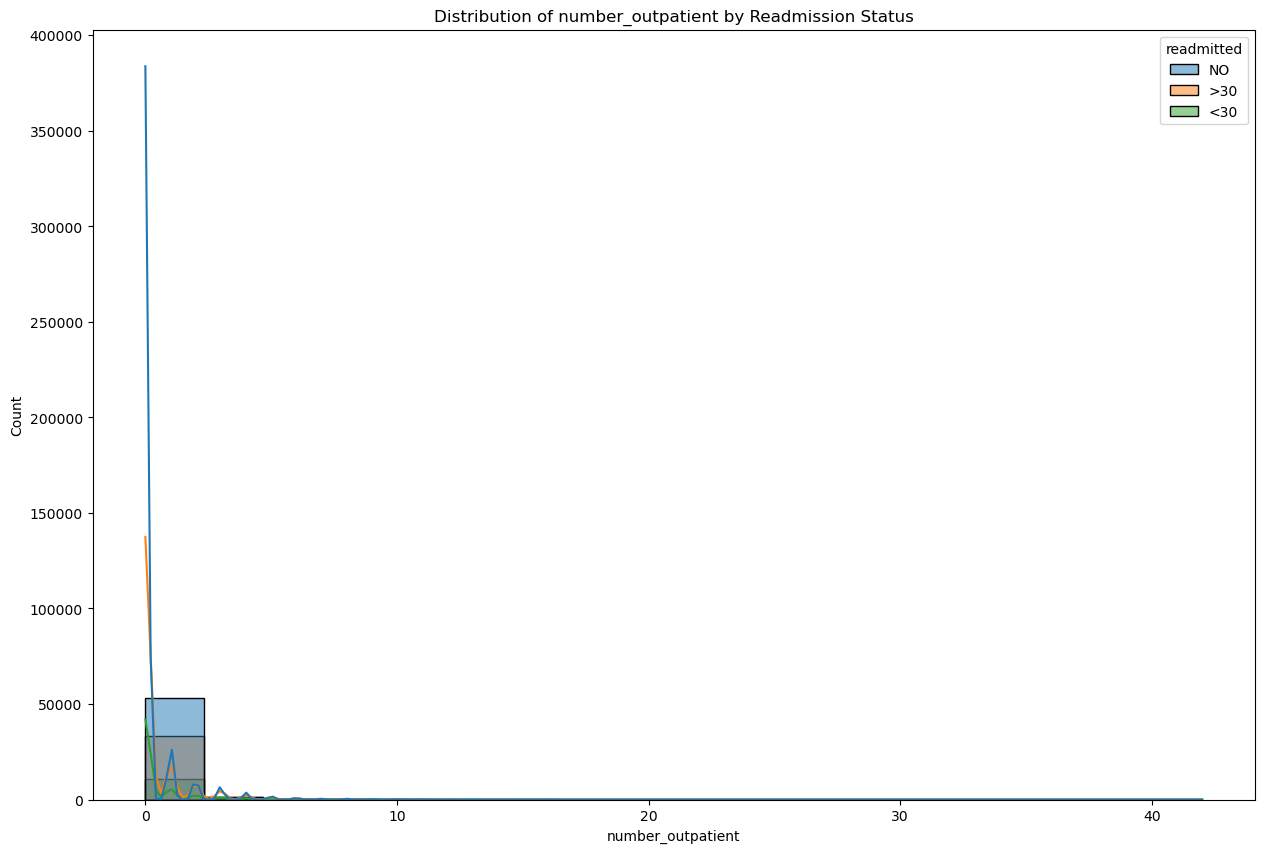

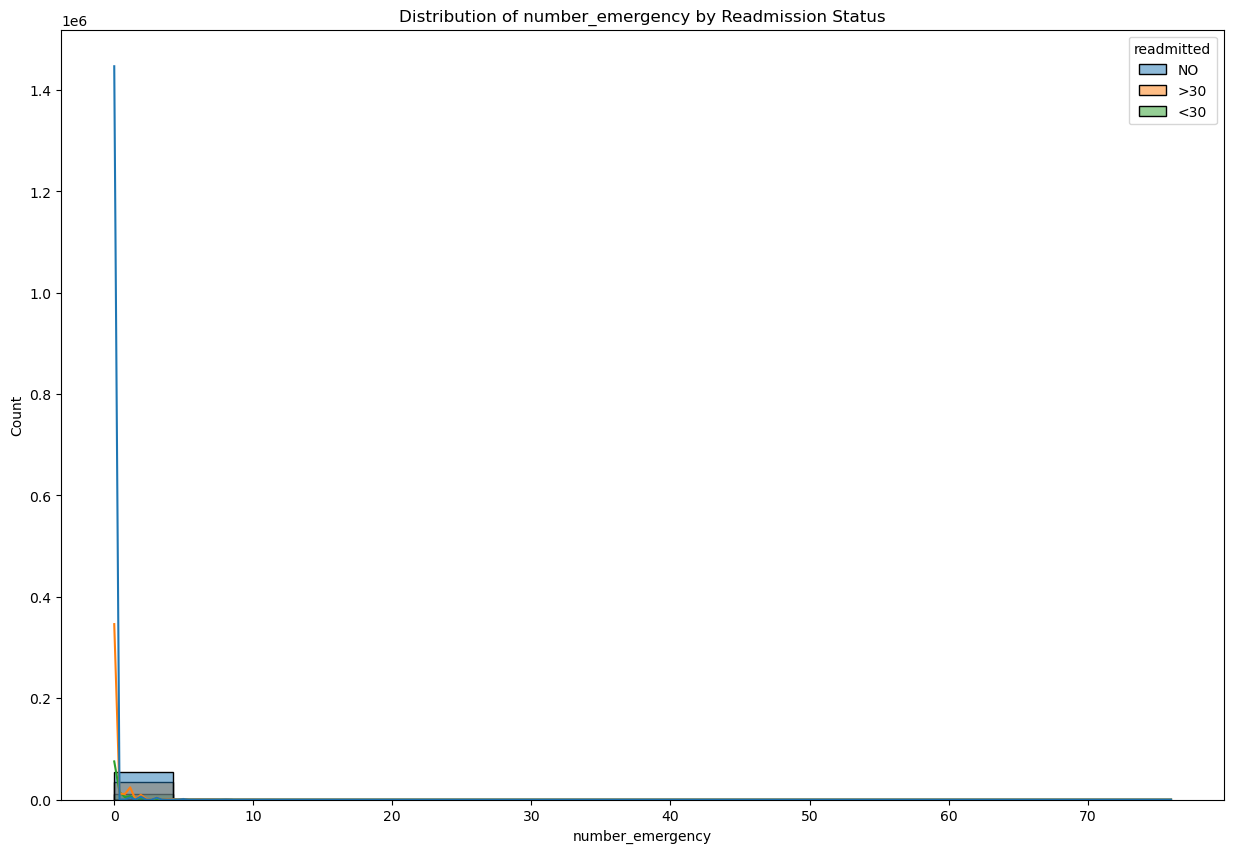

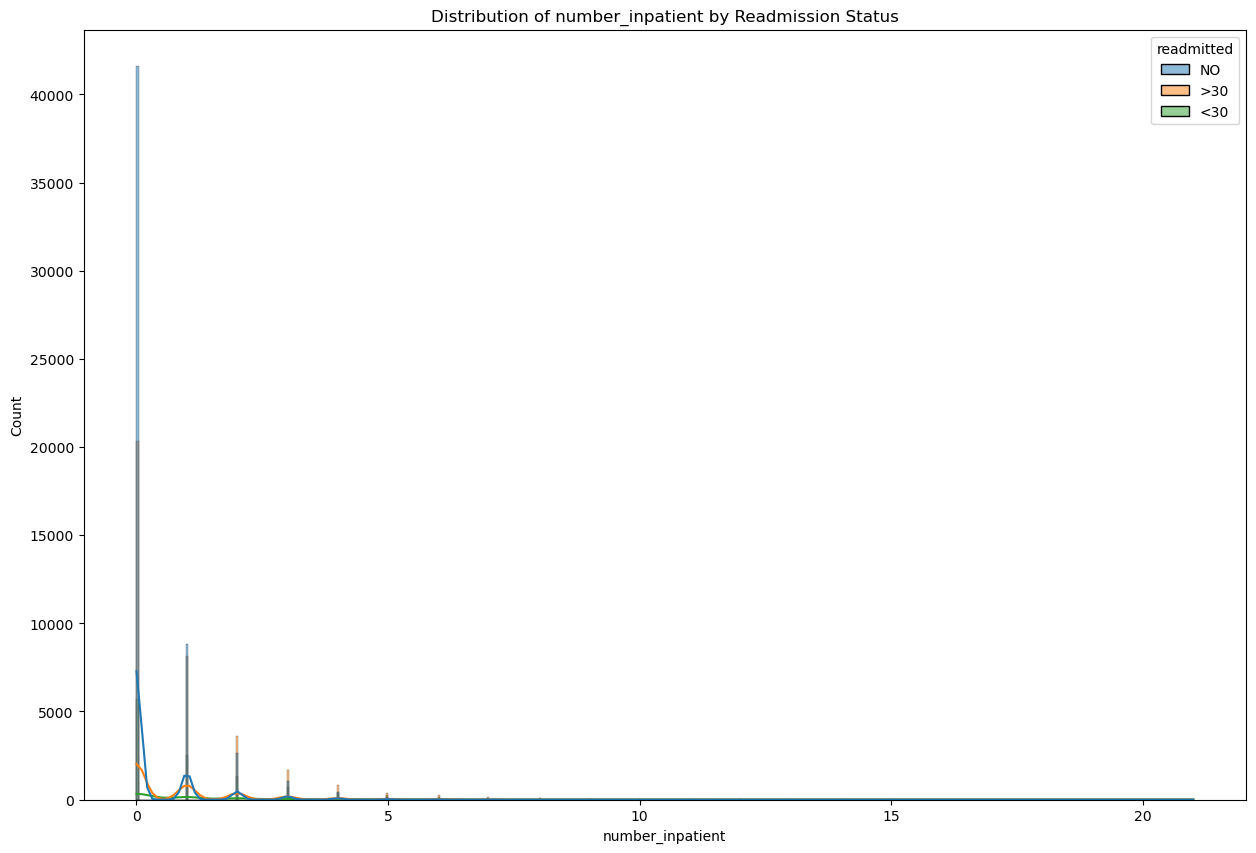

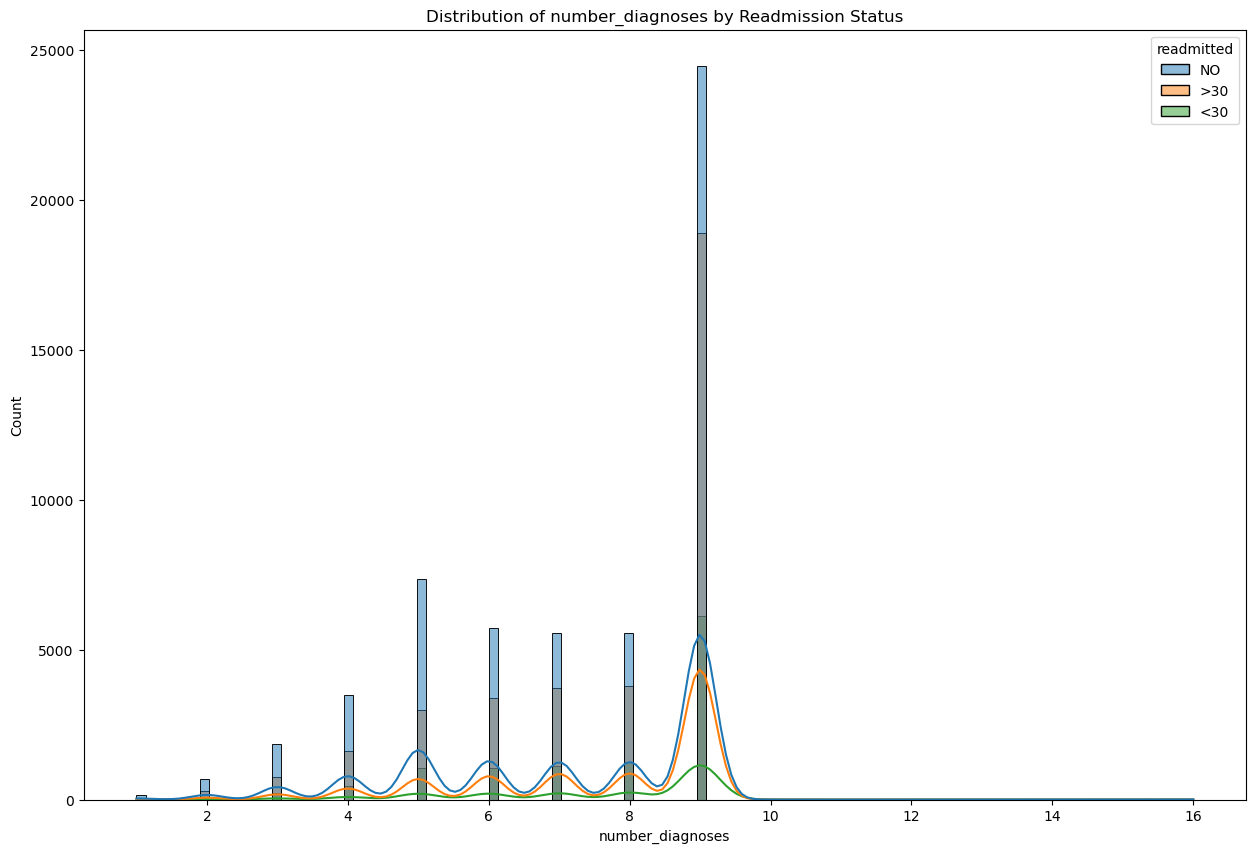

In [4]:
# Seperate out features for visualization
num_features = patient_data.select_dtypes(include='number')
# Irrelevant or categoricall
num_features.drop(['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

# Look at numerical feature distributions
for i, col in enumerate(num_features):
    plt.figure(figsize=(15, 10))
    sns.histplot(data=patient_data, x=col, hue='readmitted', kde=True)
    plt.title(f'Distribution of {col} by Readmission Status')

c:\Users\craig\anaconda3\envs\ml-env\lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 1500x1000 with 0 Axes>

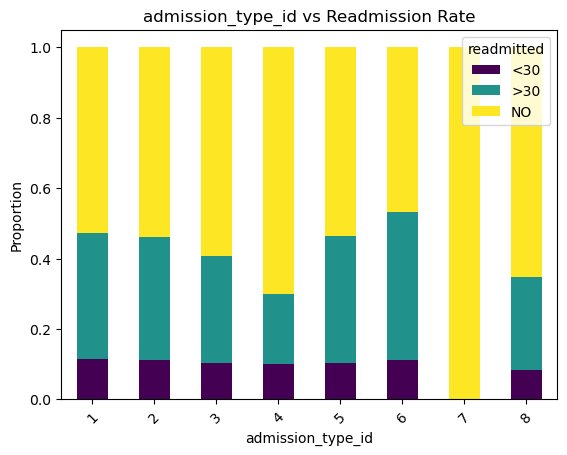

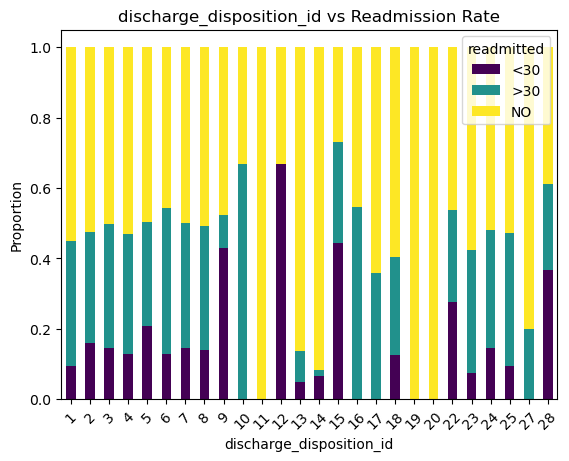

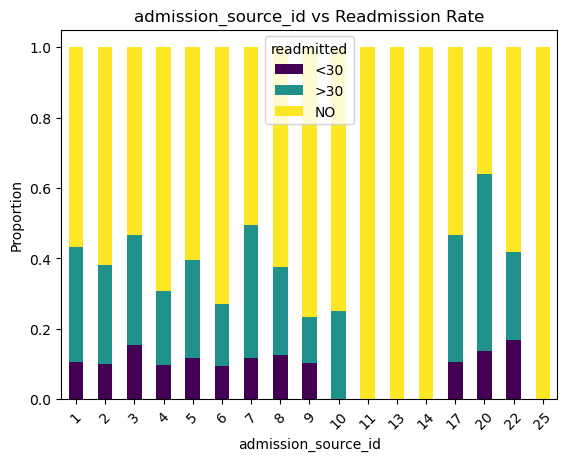

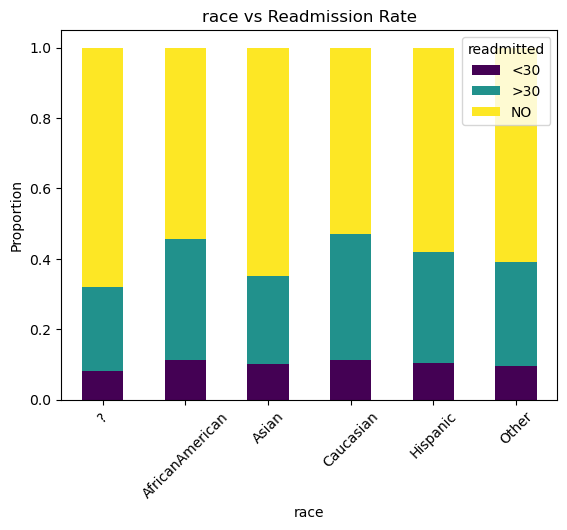

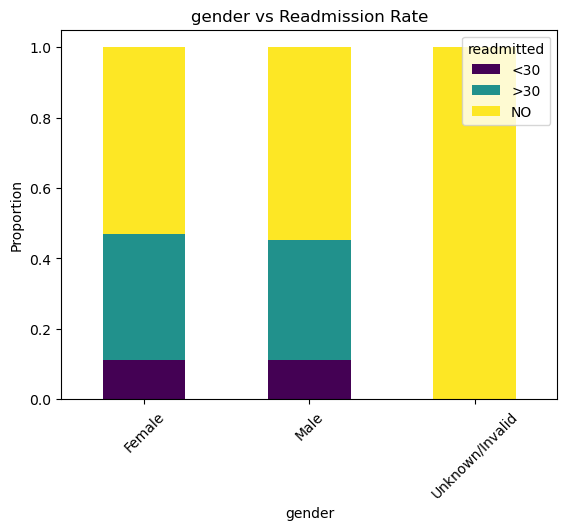

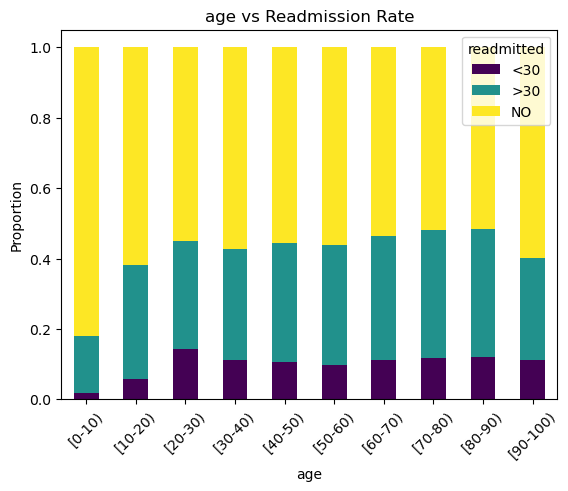

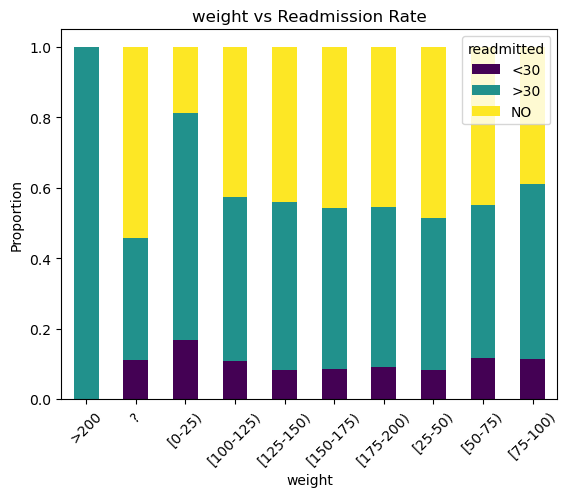

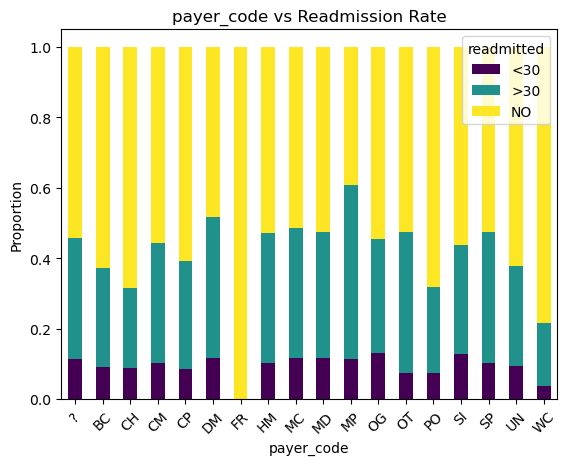

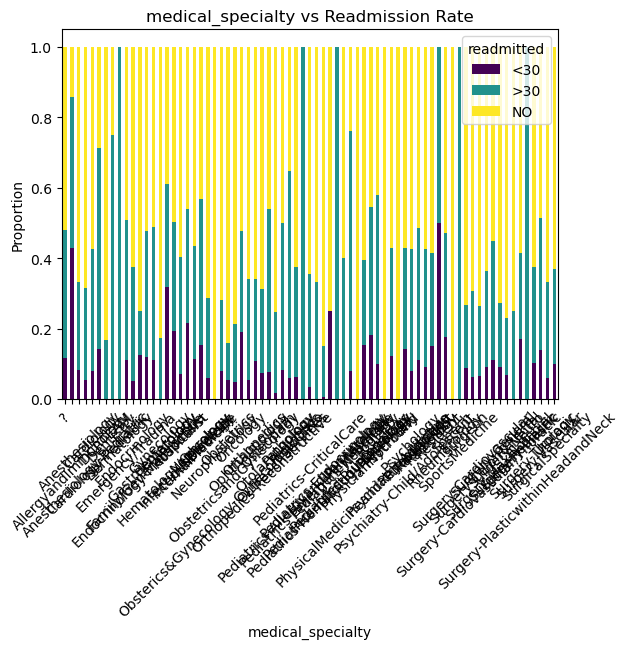

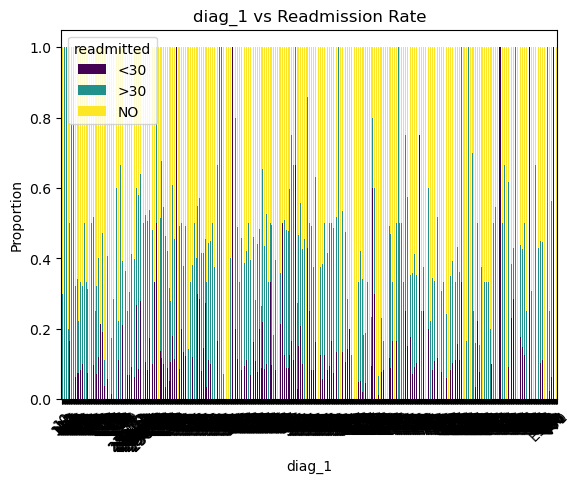

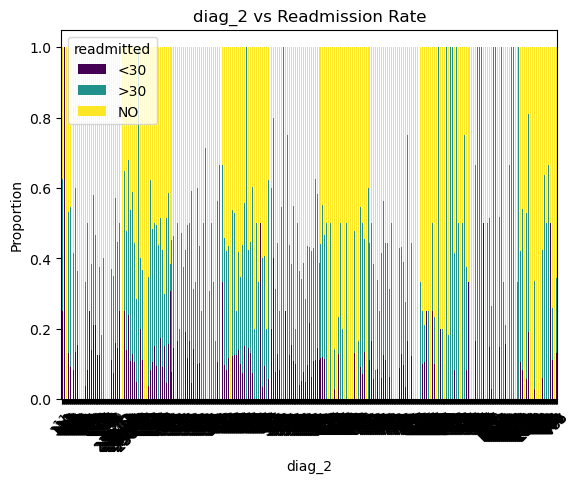

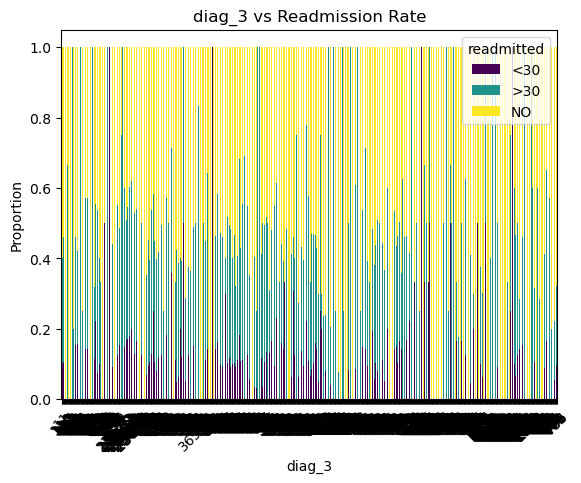

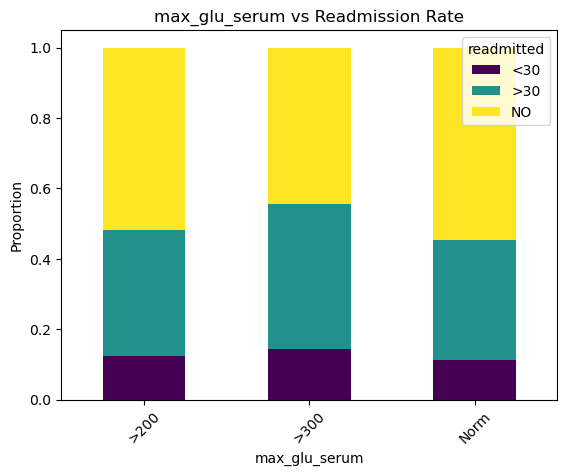

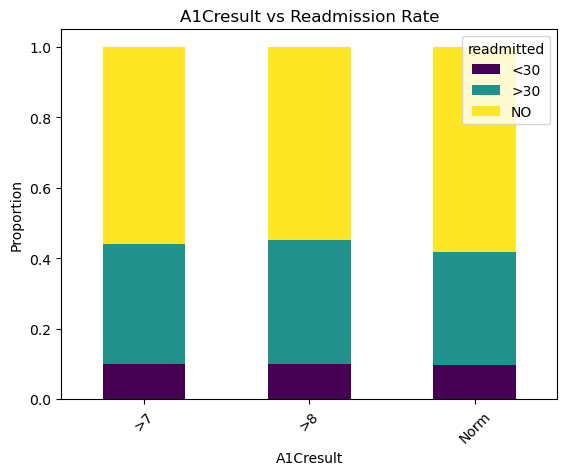

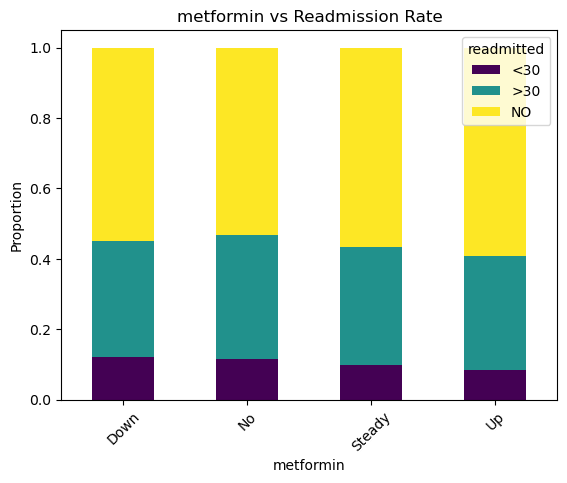

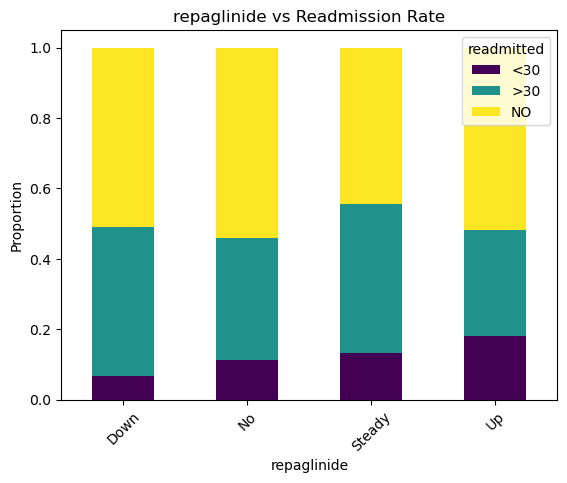

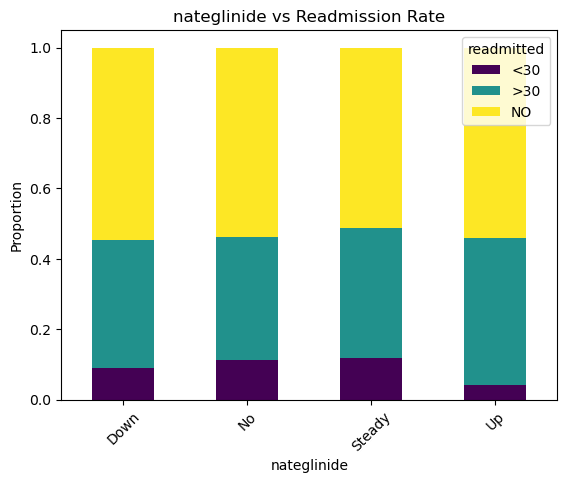

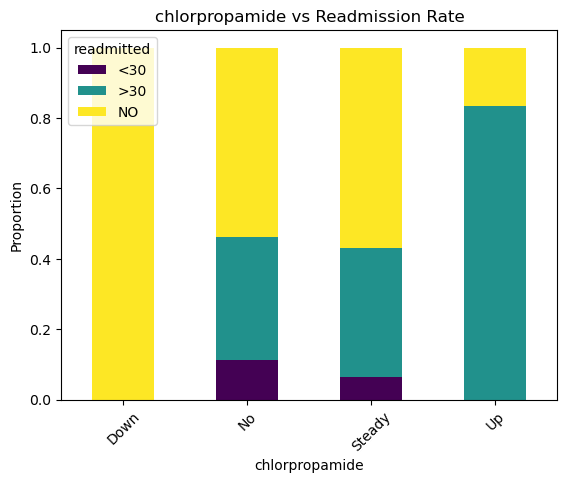

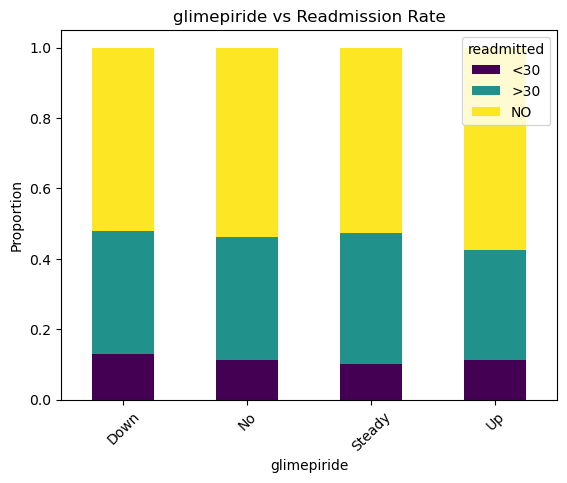

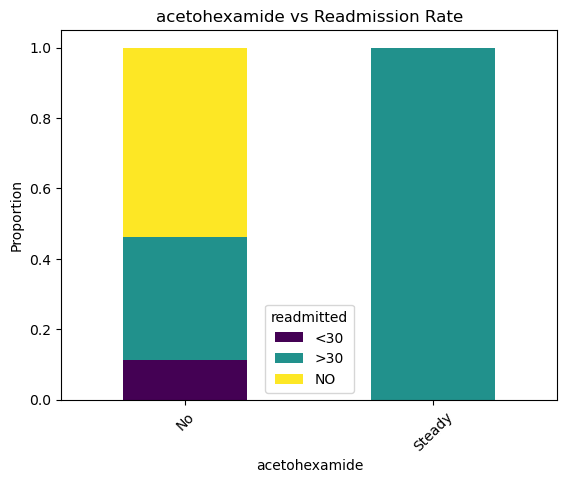

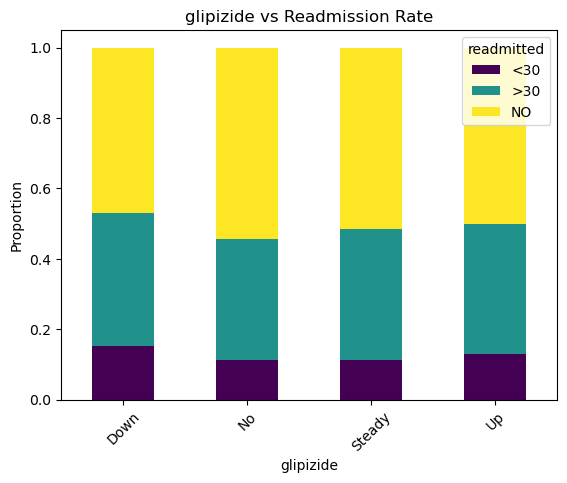

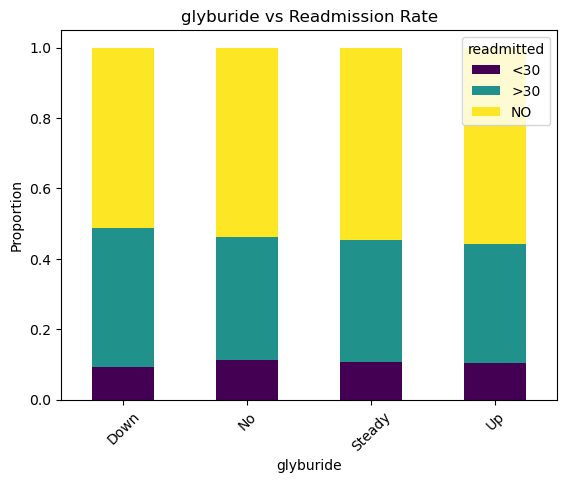

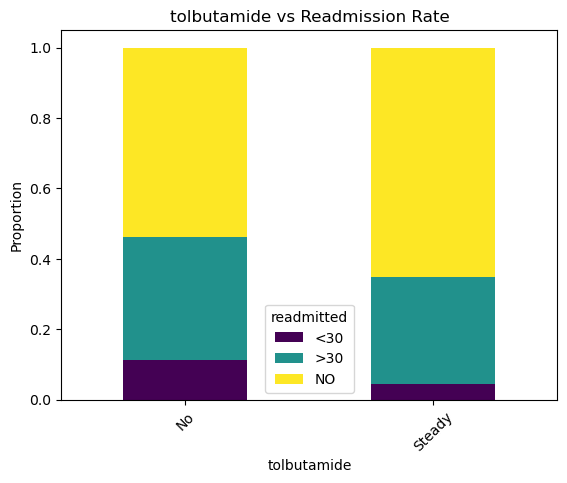

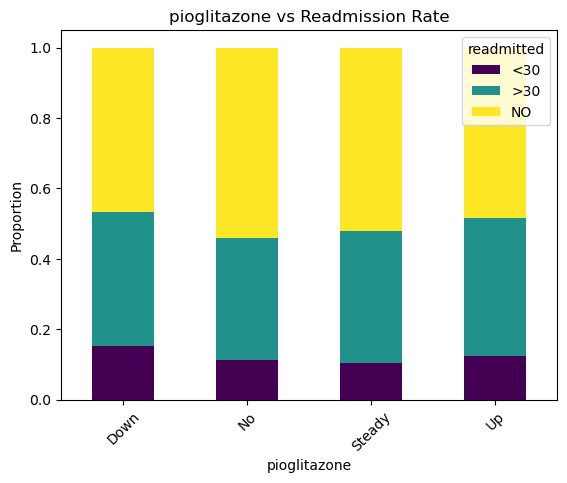

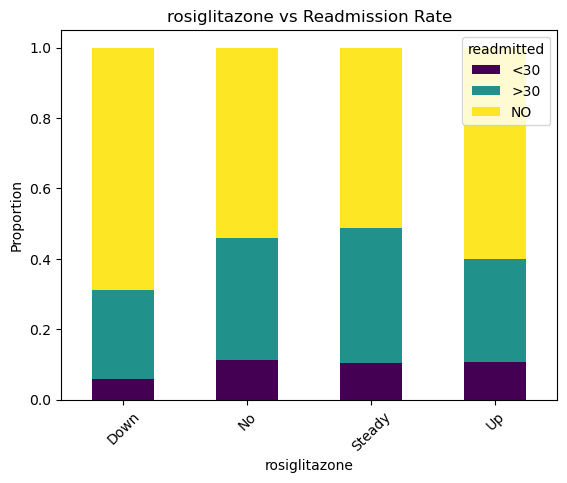

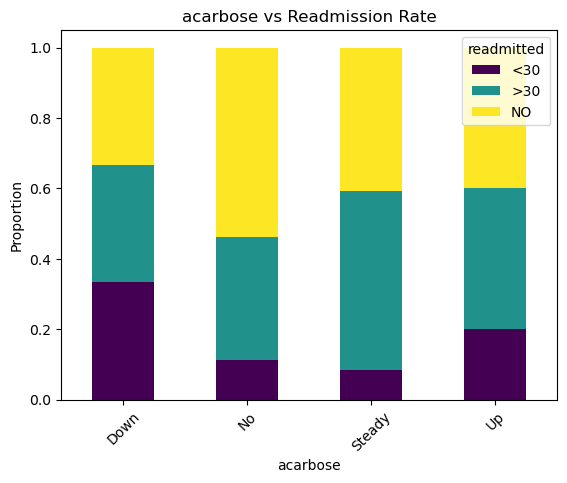

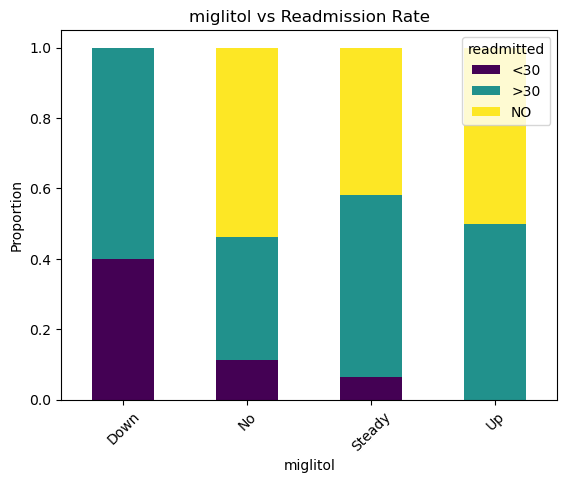

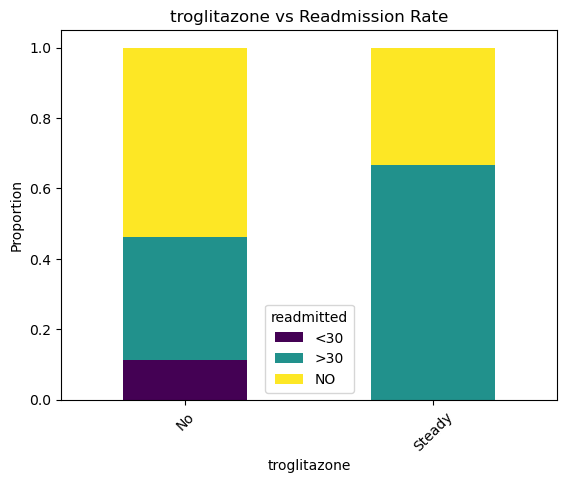

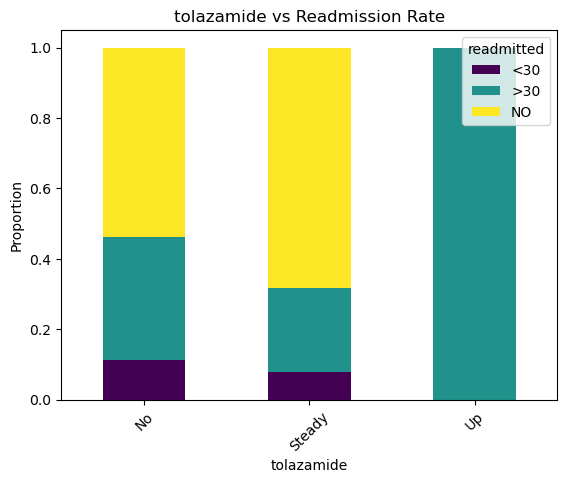

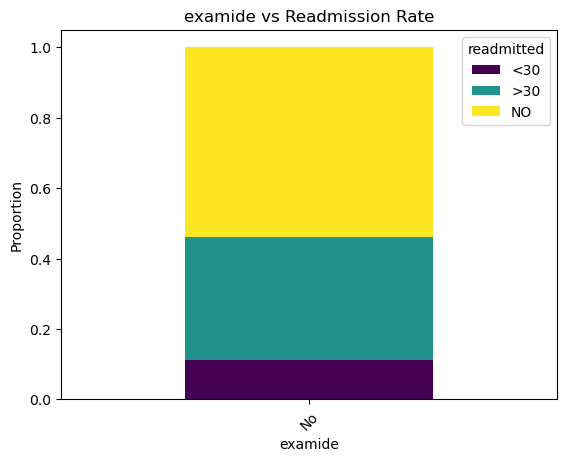

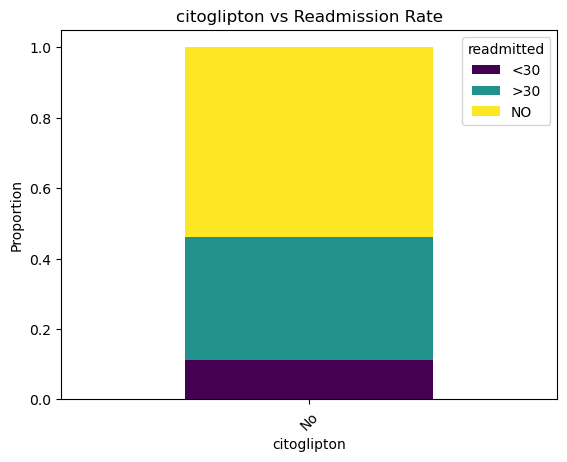

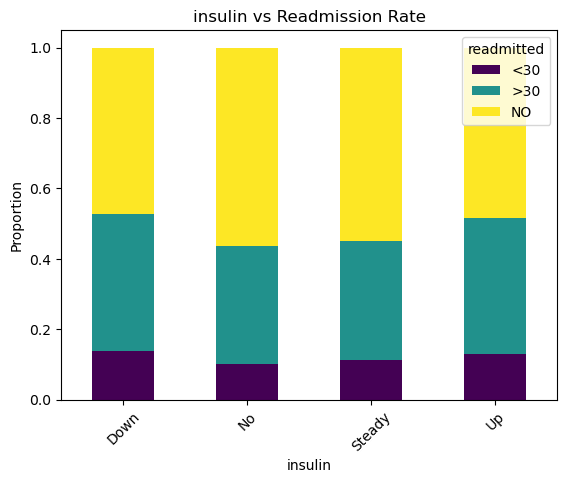

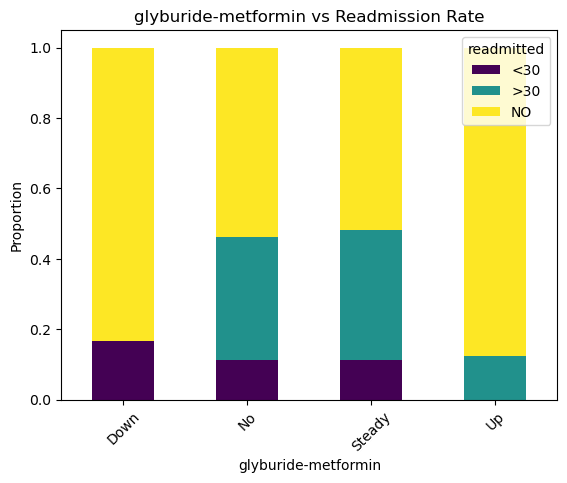

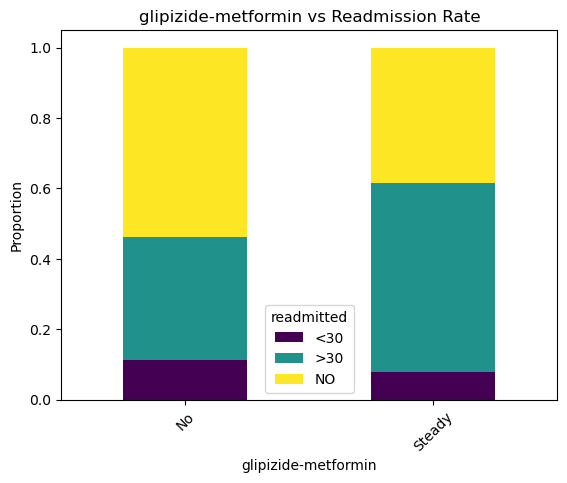

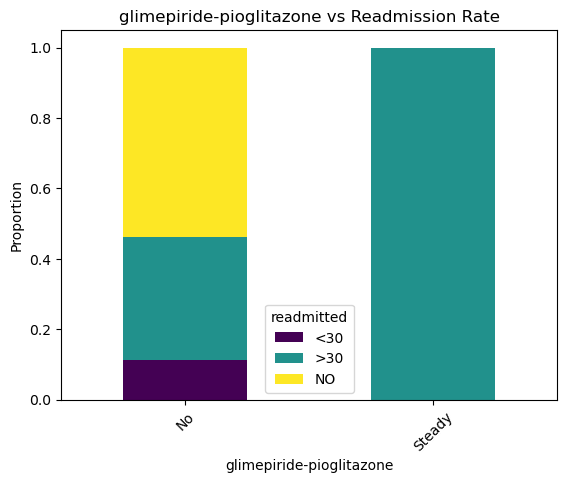

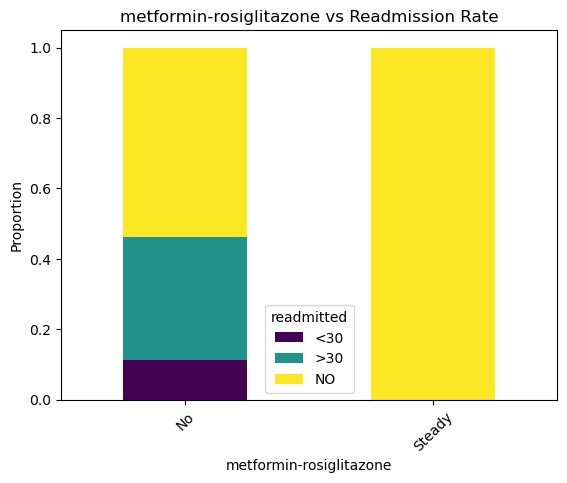

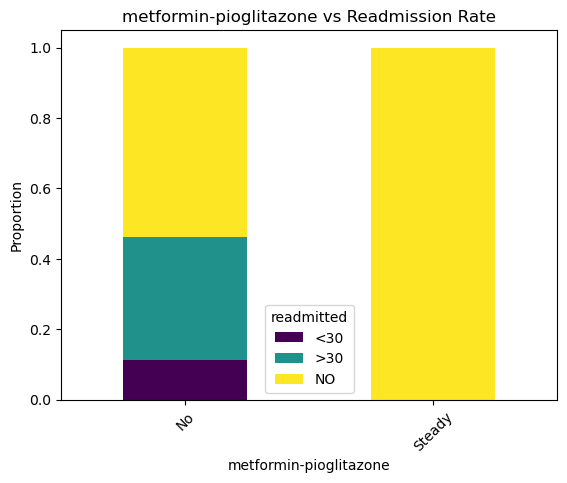

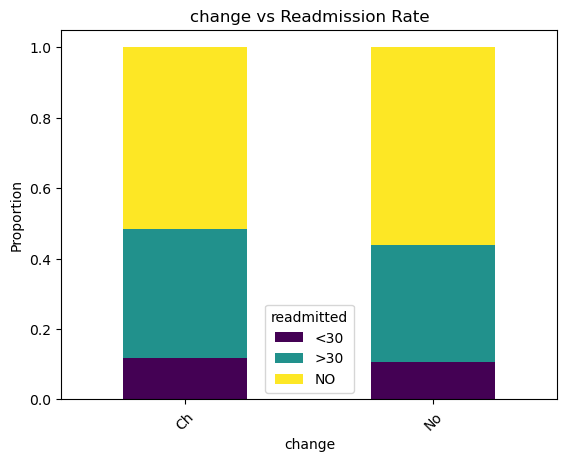

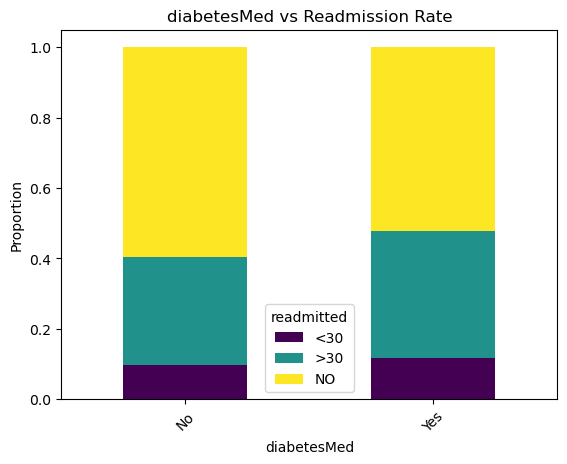

In [5]:
# Seperate out features for visualization
categorical = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
cat_columns = patient_data.select_dtypes(include='object')
cat_cols = list(cat_columns.columns)
categorical.extend(cat_cols)
categorical.remove('readmitted')
cat_features = patient_data[categorical]

# Categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_features):
    crosstab = pd.crosstab(patient_data[col], patient_data['readmitted'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'{col} vs Readmission Rate')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)

## Part 2: Implement Baseline Model
First you need to prepare the data for modeling



In [24]:
# Prepare data for modeling
# We will look to combine readmission to make this binary

# Reload the data to ensure we have clean data
patient_data = pd.read_csv("readmission_data.csv")
print("Unique values in readmitted column before mapping:", patient_data['readmitted'].unique())

# Map readmission values to binary (1 for readmitted, 0 for not readmitted)
patient_data['readmitted'] = patient_data['readmitted'].map({'<30': 1, '>30': 1, 'NO': 0})

# Check for any NaN values after mapping
if patient_data['readmitted'].isna().any():
	print("Warning: NaN values found after mapping.")
	print("Number of NaN values:", patient_data['readmitted'].isna().sum())
	# Remove rows with NaN values in readmitted column
	patient_data = patient_data.dropna(subset=['readmitted'])
	print("Removed rows with NaN values. New shape:", patient_data.shape)

print("Unique values after mapping:", patient_data['readmitted'].unique())
print("Dataset shape after cleaning:", patient_data.shape)
print("Class distribution:")
print(patient_data['readmitted'].value_counts())

# These columns hold no meaning are just unique identifiers and readmitted is our target
cols_to_drop = ['encounter_id', 'patient_nbr', 'readmitted']
X = patient_data.drop(columns=cols_to_drop)
y = patient_data['readmitted']

# Ensure we have data before splitting
if len(X) == 0:
	raise ValueError("No data available after preprocessing. Please check the data file.")

# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

Unique values in readmitted column before mapping: ['NO' '>30' '<30']
Unique values after mapping: [0 1]
Dataset shape after cleaning: (101766, 50)
Class distribution:
readmitted
0    54864
1    46902
Name: count, dtype: int64


In [25]:
# Run this cell without changes
# Preprocess data with Column Transformer pipeline
# To prevent high dimenstionality we will target encode the diagnosis codes rather than one hot encode
target_encode_cols = ['diag_1', 'diag_2', 'diag_3']
ohe_cols = [col for col in categorical if col not in target_encode_cols]
num_cols = num_features.columns

# Create the preprocessing function
num_pipe = Pipeline(steps=[('impute_num', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

ohe_pipe = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='constant', fill_value='?')),
                           ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

tarenc_pipe = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='constant', fill_value='?')),
                              ('tar_encode', TargetEncoder(target_type='binary'))])

col_trans = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                            ('cat', ohe_pipe, ohe_cols),
                                            ('tar', tarenc_pipe, target_encode_cols)],
                              remainder='passthrough')

# Need to provide y_train for the target encoder
X_train_pro = col_trans.fit_transform(X_train, y_train)
X_val_pro = col_trans.transform(X_val)
X_test_pro = col_trans.transform(X_test)

print(f"Training set: {X_train_pro.shape} samples")
print(f"Validation set: {X_val_pro.shape} samples")
print(f"Test set: {X_test_pro.shape} samples")

Training set: (61059, 220) samples
Validation set: (20353, 220) samples
Test set: (20354, 220) samples


c:\Users\craig\anaconda3\envs\ml-env\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 8, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\craig\anaconda3\envs\ml-env\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [8, 25, 33] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
# Create a baseline with two hidden layers, use the relu activation function, select an appropriate number of nodes (64, 32)
# Don't forget your output layer for binary classification
def create_baseline_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        # Use Adam
        optimizer='adam',
        # Select appropriate loss for binary classification
        loss='binary_crossentropy',
        # Evaluate based on recall
        metrics=[tf.keras.metrics.Recall()]
    )
    
    return model

# Create and train the baseline model
baseline_model = create_baseline_model(X_train_pro.shape[1])
baseline_model.summary()

# Train the model without any callbacks
baseline_history = baseline_model.fit(
    X_train_pro, y_train,
    epochs=50,  # Train for a fixed number of epochs
    batch_size=32,
    validation_data=(X_val_pro, y_val),
    verbose=1
)

c:\Users\craig\anaconda3\envs\ml-env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6466 - recall: 0.4645 - val_loss: 0.6222 - val_recall: 0.6026
Epoch 2/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 874us/step - loss: 0.6217 - recall: 0.5618 - val_loss: 0.6187 - val_recall: 0.5964
Epoch 3/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 906us/step - loss: 0.6154 - recall: 0.5774 - val_loss: 0.6183 - val_recall: 0.6011
Epoch 4/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - loss: 0.6106 - recall: 0.5849 - val_loss: 0.6192 - val_recall: 0.6082
Epoch 5/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 907us/step - loss: 0.6067 - recall: 0.5959 - val_loss: 0.6200 - val_recall: 0.5920
Epoch 6/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 924us/step - loss: 0.6028 - recall: 0.6006 - val_loss: 0.6214 - val_recall: 0.5982
Epoch 7/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 905us/step - loss: 0.5988 - recall: 0.6040 - val_loss: 0.6237 - val_recall: 0.6069
Epoch 8/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - loss: 0.5947 - recall: 0.6085 - val_loss: 0.6262

## Part 3: Visualize Training and Validation curves
Important to visualize our training curves in order to understand model limitations and adapt the next iteration. Particularly important to understand the models bias and variance (over/under fitting).

Baseline Test Recall: 0.5532


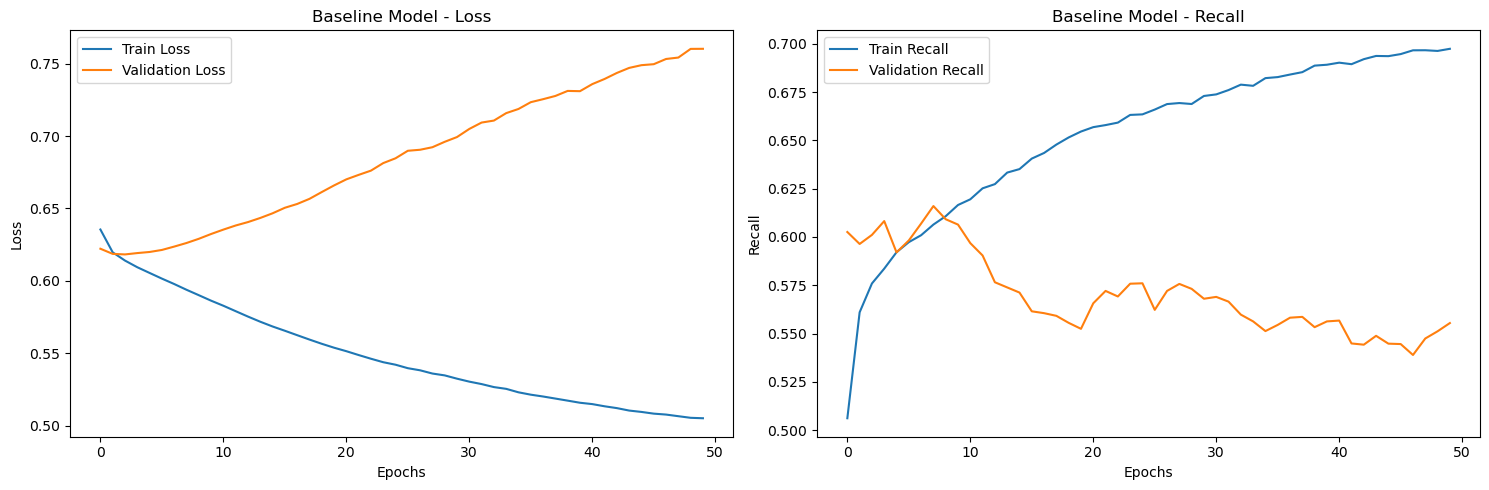

In [28]:
# Evaluate the baseline model on testing data
baseline_test_loss, baseline_test_recall = baseline_model.evaluate(X_test_pro, y_test, verbose=0)
print(f"Baseline Test Recall: {baseline_test_recall:.4f}")

# Plot the training and validation loss/accuracy curves
def plot_training_history(history, title=''):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title(f'{title} - Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot baseline model training history
plot_training_history(baseline_history, title='Baseline Model')

## Part 4: Implement Callbacks for Monitoring and Early Stopping

Clear sign of model overfitting and gradient problems. Now, let's implement callbacks to monitor training and prevent overfitting. We will also provide a more complex network to attempt to address the overfitting.

In [30]:
# Implement EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Implement ModelCheckpoint callback to save the best model
checkpoint_filepath = './best_model.keras'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True
)

# Implement TensorBoard callback for visualization
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Don't change this one
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        # Reduce learning rate by 80%
    patience=5,        # Wait 5 epochs of no improvement
    min_lr=0.000001,    # Don't go below this learning rate
    verbose=1          # Print when learning rate changes
)

# Combine all callbacks into a list
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback,
    reduce_lr
]

In [31]:
# Run this cell without changes
# Create an improved model with gradient problem mitigation strategies and train with callbacks
def create_improved_model(input_dim):
    model = Sequential()
    
    # First layer
    model.add(Input((input_dim,)))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))  
    
    # Second layer
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Use Adam optimizer with gradient clipping
    optimizer = Adam(learning_rate=0.001, clipvalue=.5)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['recall']
    )
    
    return model

# Create and compile the improved model
improved_model = create_improved_model(X_train_pro.shape[1])
improved_model.summary()

# Train the improved model with the callbacks
improved_history = improved_model.fit(
    X_train_pro, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_pro, y_val),
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.6742 - recall: 0.5380 - val_loss: 0.6276 - val_recall: 0.4060 - learning_rate: 0.0010
Epoch 2/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6307 - recall: 0.5415 - val_loss: 0.6268 - val_recall: 0.4061 - learning_rate: 0.0010
Epoch 3/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6256 - recall: 0.5550 - val_loss: 0.6254 - val_recall: 0.4048 - learning_rate: 0.0010
Epoch 4/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6241 - recall: 0.5539 - val_loss: 0.6241 - val_recall: 0.4232 - learning_rate: 0.0010
Epoch 5/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6232 - recall: 0.5639 - val_loss: 0.6226 - val_recall: 0.4344 - learning_rate: 0.0010
Epoch 6/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6210 - recall: 0.5620 - val_loss: 0.6227 - val_recall: 0.4320 - learning_rate: 0.0010
Epoch 7/100
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6206 - recall: 0.5609 - val_l

## Part 5: Analyze Training Results
Again, it is always important to look at curves. Here we should see way less overfitting and platued losses which tell us the model has gone about as far as it can go with the data at hand.

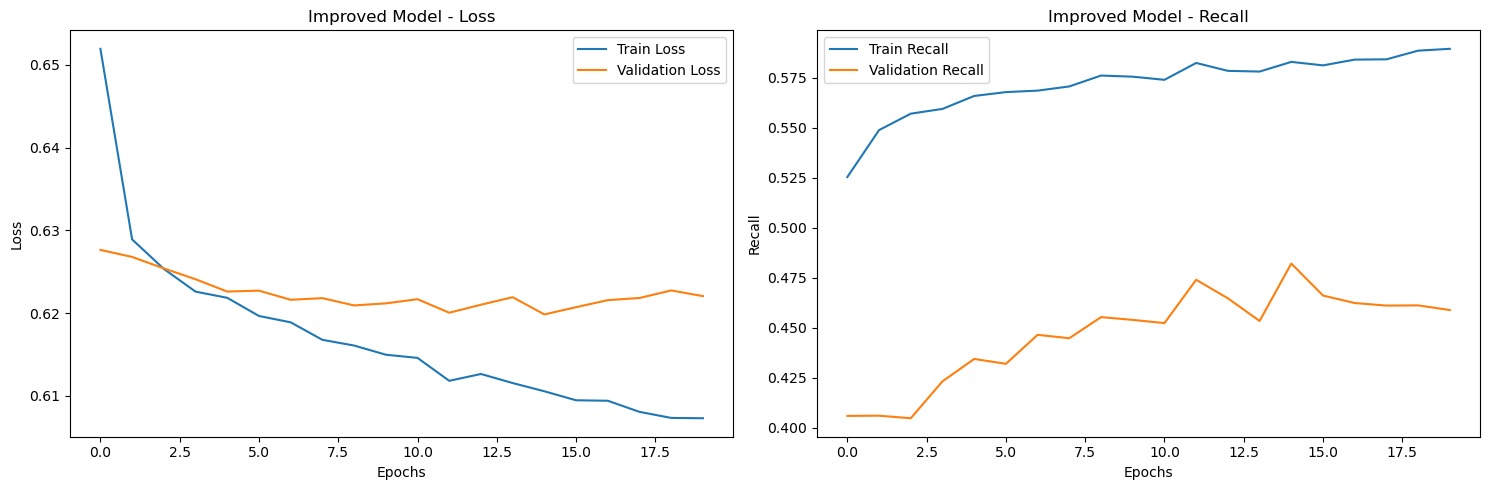

637/637 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.6229 - recall: 0.4744
Improved Model (Final) Test Recall: 0.4801
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.6229 - recall: 0.4744
Best Model (Checkpoint) Test Recall: 0.4801
Baseline Test Recall: 0.5532
Early Stopping activated at epoch 20 of 100


In [34]:
# Plot the training history with early stopping
plot_training_history(improved_history, title='Improved Model')

# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model(checkpoint_filepath)

# Evaluate the final improved model
improved_test_loss, improved_test_recall = improved_model.evaluate(X_test_pro, y_test, verbose=1)
print(f"Improved Model (Final) Test Recall: {improved_test_recall:.4f}")

# Evaluate the best model (saved by checkpoint)
best_test_loss, best_test_recall = best_model.evaluate(X_test_pro, y_test, verbose=1)
print(f"Best Model (Checkpoint) Test Recall: {best_test_recall:.4f}")

# Compare with baseline
print(f"Baseline Test Recall: {baseline_test_recall:.4f}")
print(f"Early Stopping activated at epoch {len(improved_history.history['loss'])} of 100")

In [35]:
# Load TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard
%tensorboard --logdir=logs/fit

# Note: TensorBoard output will appear in the notebook
# We can examine histograms of weights and gradients, model graph,
# and other useful visualizations

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 29808), started 0:00:50 ago. (Use '!kill 29808' to kill it.)

When training complex machine learning models, the relationship between model complexity and data quality is crucial. Even the most sophisticated neural network architecture can plateau if the loss stops decreasing, indicating that the model has reached the limits of what it can learn from the available data. At this point, rather than adding more layers or parameters, the focus should shift to improving data quality, diversity, and relevance to the specific task. Better data—whether that means more accurate labels, more representative samples, or enhanced feature engineering—often proves more valuable than increased model complexity for breaking through performance plateaus.

## Part 6: Reflection and Documentation

### Question 1: How did early stopping affect the training process and final model performance?

Training Process Impact
- Early Stopping at Epoch 20 (of 100)
Training halted after 20 epochs due to no improvement in val_loss.
- Learning Rate Reduction Confirmed Plateau
At epoch 20, ReduceLROnPlateau reduced the learning rate from 0.001 → 0.0002; the model had stalled.
- No Meaningful Gains After Epoch 15
Validation loss stabilized around 0.620–0.622 after epoch 15.
- Overfitting Avoided
Training loss continued to decrease while validation loss plateaued. Early stopping restored the best weights from epoch 15 (val_loss = 0.6198), limiting further overfitting.

Model Performance Impact
- Best Checkpoint Recall: 48.01%
- Worse Than Baseline (55.32% Recall)
- Significant Compute Savings


### Question 2: What patterns did you observe in the training and validation curves?

Loss & Recall Behavior
- Loss dropped sharply in the first few epochs (≈0.67 → ≈0.62)
- Training loss kept decreasing while validation loss plateaued after epoch ~12 (overfitting). 
- Optimization remained stable, with no large validation-loss swings.
- Training recall rose steadily (~52% → ~59%), but validation recall was volatile (≈40–48%) and never converged. 
- By epoch 20, a ~13-point train–validation recall gap (59% vs. 46%) - reinforces overfitting.

### Question 3: In a healthcare context like this one, why is it particularly important to prevent overfitting?

Patient risk — An overfit model may look accurate historically but fail on new patients, causing missed high-risk cases and unnecessary interventions. Both harm outcomes and waste clinical effort.

Poor generalization — Healthcare data varies across hospitals, populations, and care practices. A model tuned to one facility's past patterns may not reliably predict future patients.

Resource waste and cost — Readmission models drive allocation of services. Unreliable predictions misdirect resources and can trigger significant value-based care penalties.

Trust and compliance — Clinicians abandon models that fail in practice. Regulators require explainable, fair, and consistently reliable systems.

A model with 55% training recall and only 48% validation recall would miss most patients who will be readmitted. In healthcare, that risk is unacceptable. It’s better to acknowledge the model’s limits than deploy a system that appears accurate but fails on real patients.

### Question 4: How would you explain the benefits of your monitoring approach to non-technical healthcare staff?

The Problem

Model training is like training a medical resident: memorization of past cases doesn’t help with new patients. That failure mode—overfitting—is especially dangerous in healthcare.

Our Safeguards
- Early Stopping: We stop training when validation performance stops improving (patience = 5). Prevents memorization and saves compute.
- Model Checkpointing: We continuously save the best-performing model. Ensures the optimal version is never lost.
- Training Curves: We track loss and recall on training vs. validation data. Exposes generalization failures early.

Real-World Impact
Without monitoring, models can overtrain and fail in production. With monitoring, training stopped at epoch 20 (not 100), saving ~80% of compute and clearly revealing performance limits. The system did its job; it showed the model plateaued at 48% recall—below clinical thresholds. That insight is a success. We are able to identify limitations early so we don't deploy a model that appears accurate but fails on new patients.

## Summary of Implemented Techniques

In this lab, we've implemented and demonstrated several key techniques for improving neural network training:

1. **Early Stopping**: Automatically halts training when validation performance stops improving, preventing overfitting and saving computational resources.

2. **Model Checkpointing**: Saves the best-performing model during training, ensuring we retain the optimal weights even if training continues past the ideal point.

3. **Training Visualization**: Using TensorBoard and custom plotting functions to monitor and interpret the training process in real-time.

4. **BatchNormalization**: Stabilizes the distribution of layer inputs during training, helping to prevent vanishing/exploding gradients.

5. **Gradient Clipping**: Limits the size of gradient updates to prevent unstable training.

6. **Advanced Activation Functions**: Using LeakyReLU instead of standard ReLU to prevent "dead neurons" and improve gradient flow.

8. **Dropout**: Randomly deactivating neurons during training to prevent overfitting and improve generalization.

By combining these techniques, we were able to improve model performance and training stability if only minorly, resulting in a more reliable patient readmission prediction model that would perform better in real-world healthcare settings. Ultimately, because our final model is accounting for potential issues and still not performing as well as we hoped, it becomes a matter of needing better and more data to predict readmission.

These monitoring and optimization techniques are applicable across a wide range of deep learning applications, not just healthcare, and should be considered essential components of any robust deep learning workflow.